In this tutorial we demonstrate how to

- Setup the optimization experiment (Config)
- Load a judgement list (load_judge_data)
- Run the optimization (compute_queries_ndcg)
- Update the scoring profile with best optimization run weights
- Analyze optimization results (optimization_history and plots)


We conclude by noting the difference between ndcg gains in a:
- small optimization study (this tutorial with 25 trials and 20 queries)
vs
- larger optimization study (separate work with 250 trials and 1K queries)


In [1]:
import pathlib
import warnings
# warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from time import time
import numpy as np
import pandas as pd
import optuna

from lib_utils import load_judge_data, compute_queries_ndcg, optimization_objective, update_scoring_profile



In [2]:
# SETUP THE OPTIMIZATION EXPERIMENT: PARAMS AND KEYS
class Config(object):
    # JUDGEMENT DATA PARAMS
    judge_url_key = "url"  # assumed in data
    judge_query_key = "query"  # assumed in data
    judge_posn_key = "position"  # assumed in data
    judge_rlv_key = "relevance"  # not assumed in data
    compute_relevance_method = "reverse_position"  # method to compute relevance
    
    # SEARCH API PARAMS
    profile_name = "ivbarrie_test" # scoring profile name
    index_version = "2021-06-01" # Azure search api version
    query_type = "simple" 
    api_query_key = "Query"
    api_url_key = "url"  # field name in index
    api_value_key = "value"
    api_score_key = "score"
    api_no_result_val = "__no_result__"
    azure_search_service_url = f"https://{your-search-service}.search.windows.net/indexes/{index-name}/" # replace search service and index name with valud values
    query_url = azure_search_service_url + "docs/search?api-version=%s-preview" % index_version
    score_profile_index_url = azure_search_service_url + "?api-version=%s" % index_version
    user_agent = "Python"  # white listed name
    query_api_code = "{Your query key}"
    admin_api_code = "{Search admin key}"
    
    # PATHS
    main_dir = r"{path to judgement list}"
    judge_fname = r"{judgement_list.csv}"
    optimization_history_fname = "optimization_history.csv"
    judge_filepath = pathlib.PurePath(main_dir, judge_fname)
    optimization_history_filepath = pathlib.PurePath(main_dir, optimization_history_fname)
    
    # OPTIMIZATION PARAMS
    ndcg_key = "ndcg"
    n_queries = 20  # num queries to sample from judgement list
    top_k_srch_results = 5  # num top search results per query for azure search calls
    # TODO: early stopping or ndcg = 1.0 (perfect)
    n_optimization_trials = 25  # num optimization trials, NB: will go all the away
    exception_queries = []  # capture search terms that don't return resuts from index
    
    # weight params
    weight_fields = ["content", "title", "toc/heading"]   # available weight fields in search index
    search_fields_str = ','.join(f for f in weight_fields)
    min_weight = 0.1  # min weight val -- recommend to start small, e.g. 0.1 or 1.0
    max_weight = 150.1  # max weight val -- recommended medium/large, e.g. 10 or 100
    weight_steps = 2  # increment step size per weight value applied to weight field


In [4]:
# LOAD JUDGEMENT LIST

judge_data = load_judge_data(Config)
# Change Config.n_queries for testing purposes
Config.selected_judge_queries = list(set(judge_data[Config.judge_query_key]))[ : Config.n_queries]
judge_data = judge_data[judge_data[Config.judge_query_key].isin(Config.selected_judge_queries)]

# Look at sample data
print(judge_data.head())

                                                    url  \
5102  https://docs.microsoft.com/en-us/skypeforbusin...   
5103  https://docs.microsoft.com/en-us/windows-hardw...   
5104  https://docs.microsoft.com/en-us/windows-hardw...   
5105  https://docs.microsoft.com/en-us/windows-hardw...   
5106  https://docs.microsoft.com/en-us/windows-hardw...   

                                                  title  position  relevance  
5102                        USB audio and video devices         0         20  
5103  Setting Up Kernel-Mode Debugging over a USB 2....         1         19  
5104  Install Windows from a USB Flash Drive | Micro...         2         18  
5105  WinPE: Store or split images to deploy Windows...         3         17  
5106  Setting Up Kernel-Mode Debugging over a USB 3....         4         16  


NOTES: 
- "relevance" should be in descending order of importance
- "position" can refer to the place a result appears relative to top, so position = 0 may mean top result
- "title" is a sample feature; an optimal weight for it will be explored

In [6]:
# Compute baseline ndcg
baseline_start = time()
baseline_result = compute_queries_ndcg(judge_data=judge_data, Config=Config)
baseline_end = time()
baseline_avg_ndcg = float(baseline_result[Config.ndcg_key].mean())
baseline_run_secs = baseline_end - baseline_start
print('baseline ndcg took %0.2f seconds' % baseline_run_secs)

Exception for querying: ClassInitialize
Check that ClassInitialize returns results in your index
baseline ndcg took 16.89 seconds


In [7]:
print("Baseline avg NDCG on %s profile is: %0.4f" % (Config.profile_name, baseline_avg_ndcg))
print("Queries that returned no results from index:\n%s" % Config.exception_queries)

Baseline avg NDCG on ivbarrie_test profile is: 0.5783
Queries that returned no results from index:
['ClassInitialize']


In [8]:
# RUN OPTIMIZATION
# reset exception queries for consistency
Config.exception_queries = []
print('num trials: %d' % Config.n_optimization_trials)
opt_start = time()
study = optuna.create_study(direction='maximize')
study.optimize(optimization_objective(judge_data=judge_data, 
                                      Config=Config), 
               catch=(Exception, ), 
               n_trials=Config.n_optimization_trials)
opt_end = time()

# NOTE: progress bars and exploration/exploitation tradeoffs

num trials: 20
setting weights {"weight": {"content": 138.1, "title": 124.1, "toc/heading": 134.1}}
Exception for querying: ClassInitialize
Check that ClassInitialize returns results in your index


[I 2021-06-01 23:10:10,760] Finished trial#0 resulted in value: 0.5483620433317006. Current best value is 0.5483620433317006 with parameters: {'content_weight': 138.1, 'title_weight': 124.1, 'toc/heading_weight': 134.1}.


setting weights {"weight": {"content": 100.1, "title": 102.1, "toc/heading": 84.1}}


[I 2021-06-01 23:11:01,792] Finished trial#1 resulted in value: 0.5405725930813323. Current best value is 0.5483620433317006 with parameters: {'content_weight': 138.1, 'title_weight': 124.1, 'toc/heading_weight': 134.1}.


setting weights {"weight": {"content": 74.1, "title": 20.1, "toc/heading": 48.1}}


[I 2021-06-01 23:11:46,765] Finished trial#2 resulted in value: 0.5704261685913861. Current best value is 0.5704261685913861 with parameters: {'content_weight': 74.1, 'title_weight': 20.1, 'toc/heading_weight': 48.1}.


setting weights {"weight": {"content": 76.1, "title": 142.1, "toc/heading": 60.1}}


[I 2021-06-01 23:12:50,966] Finished trial#3 resulted in value: 0.5426282261922126. Current best value is 0.5704261685913861 with parameters: {'content_weight': 74.1, 'title_weight': 20.1, 'toc/heading_weight': 48.1}.


setting weights {"weight": {"content": 20.1, "title": 70.1, "toc/heading": 16.1}}


[I 2021-06-01 23:12:56,336] Finished trial#4 resulted in value: 0.5690503033291455. Current best value is 0.5704261685913861 with parameters: {'content_weight': 74.1, 'title_weight': 20.1, 'toc/heading_weight': 48.1}.


setting weights {"weight": {"content": 10.1, "title": 94.1, "toc/heading": 120.1}}


[I 2021-06-01 23:13:05,064] Finished trial#5 resulted in value: 0.5519254485265874. Current best value is 0.5704261685913861 with parameters: {'content_weight': 74.1, 'title_weight': 20.1, 'toc/heading_weight': 48.1}.


setting weights {"weight": {"content": 20.1, "title": 120.1, "toc/heading": 14.1}}


[I 2021-06-01 23:13:10,553] Finished trial#6 resulted in value: 0.577370282405937. Current best value is 0.577370282405937 with parameters: {'content_weight': 20.1, 'title_weight': 120.1, 'toc/heading_weight': 14.1}.


setting weights {"weight": {"content": 14.1, "title": 132.1, "toc/heading": 34.1}}


[I 2021-06-01 23:13:16,145] Finished trial#7 resulted in value: 0.5860859280503284. Current best value is 0.5860859280503284 with parameters: {'content_weight': 14.1, 'title_weight': 132.1, 'toc/heading_weight': 34.1}.


setting weights {"weight": {"content": 134.1, "title": 36.1, "toc/heading": 50.1}}


[I 2021-06-01 23:13:21,704] Finished trial#8 resulted in value: 0.6180178265341553. Current best value is 0.6180178265341553 with parameters: {'content_weight': 134.1, 'title_weight': 36.1, 'toc/heading_weight': 50.1}.


setting weights {"weight": {"content": 40.1, "title": 98.1, "toc/heading": 144.1}}


[I 2021-06-01 23:13:26,561] Finished trial#9 resulted in value: 0.5227428606839513. Current best value is 0.6180178265341553 with parameters: {'content_weight': 134.1, 'title_weight': 36.1, 'toc/heading_weight': 50.1}.


setting weights {"weight": {"content": 150.1, "title": 12.1, "toc/heading": 94.1}}


[I 2021-06-01 23:13:32,029] Finished trial#10 resulted in value: 0.5926223835222878. Current best value is 0.6180178265341553 with parameters: {'content_weight': 134.1, 'title_weight': 36.1, 'toc/heading_weight': 50.1}.


setting weights {"weight": {"content": 148.1, "title": 6.1, "toc/heading": 106.1}}


[I 2021-06-01 23:13:37,372] Finished trial#11 resulted in value: 0.6278291607996435. Current best value is 0.6278291607996435 with parameters: {'content_weight': 148.1, 'title_weight': 6.1, 'toc/heading_weight': 106.1}.


setting weights {"weight": {"content": 126.1, "title": 48.1, "toc/heading": 110.1}}


[I 2021-06-01 23:13:42,562] Finished trial#12 resulted in value: 0.616478406503255. Current best value is 0.6278291607996435 with parameters: {'content_weight': 148.1, 'title_weight': 6.1, 'toc/heading_weight': 106.1}.


setting weights {"weight": {"content": 120.1, "title": 36.1, "toc/heading": 72.1}}


[I 2021-06-01 23:13:48,034] Finished trial#13 resulted in value: 0.6333806948760575. Current best value is 0.6333806948760575 with parameters: {'content_weight': 120.1, 'title_weight': 36.1, 'toc/heading_weight': 72.1}.


setting weights {"weight": {"content": 108.1, "title": 2.1, "toc/heading": 76.1}}


[I 2021-06-01 23:13:53,470] Finished trial#14 resulted in value: 0.6278291607996435. Current best value is 0.6333806948760575 with parameters: {'content_weight': 120.1, 'title_weight': 36.1, 'toc/heading_weight': 72.1}.


setting weights {"weight": {"content": 150.1, "title": 50.1, "toc/heading": 104.1}}


[I 2021-06-01 23:14:01,619] Finished trial#15 resulted in value: 0.6336794972370161. Current best value is 0.6336794972370161 with parameters: {'content_weight': 150.1, 'title_weight': 50.1, 'toc/heading_weight': 104.1}.


setting weights {"weight": {"content": 116.1, "title": 60.1, "toc/heading": 68.1}}


[I 2021-06-01 23:14:11,080] Finished trial#16 resulted in value: 0.5204011774011118. Current best value is 0.6336794972370161 with parameters: {'content_weight': 150.1, 'title_weight': 50.1, 'toc/heading_weight': 104.1}.


setting weights {"weight": {"content": 92.1, "title": 38.1, "toc/heading": 92.1}}


[I 2021-06-01 23:14:23,753] Finished trial#17 resulted in value: 0.5899750993458263. Current best value is 0.6336794972370161 with parameters: {'content_weight': 150.1, 'title_weight': 50.1, 'toc/heading_weight': 104.1}.


setting weights {"weight": {"content": 150.1, "title": 32.1, "toc/heading": 126.1}}


[I 2021-06-01 23:15:42,184] Finished trial#18 resulted in value: 0.6213886371733937. Current best value is 0.6336794972370161 with parameters: {'content_weight': 150.1, 'title_weight': 50.1, 'toc/heading_weight': 104.1}.


setting weights {"weight": {"content": 84.1, "title": 60.1, "toc/heading": 106.1}}


[I 2021-06-01 23:15:51,498] Finished trial#19 resulted in value: 0.5749890868491415. Current best value is 0.6336794972370161 with parameters: {'content_weight': 150.1, 'title_weight': 50.1, 'toc/heading_weight': 104.1}.


In [9]:
# Compute optimization time
opt_run_time = opt_end - opt_start
print('optimization for %d total trials took %0.2f seconds' % \
      (Config.n_optimization_trials, opt_run_time))

# NOTE: for thousands of query in judgement list, consider async utils

optimization for 20 total trials took 349.09 seconds


In [10]:
# Save optimization history
optimization_history = study.trials_dataframe()  # DataFrame
optimization_history.to_csv(Config.optimization_history_filepath, index=False)

In [11]:
# SUMMARIZE RESULTS

trial_argmax = optimization_history['user_attrs']['ndcg_avg'].idxmax()
best_weights = optimization_history['user_attrs']['params'][trial_argmax]
best_ndcg = optimization_history['user_attrs']['ndcg_avg'].max()

print('best avg ndcg value obtained: %0.2f' % best_ndcg)
relative_improve = (best_ndcg - baseline_avg_ndcg) / baseline_avg_ndcg
print('improvement over baseline: %0.1f%%' % (100.0 * relative_improve))

best avg ndcg value obtained: 0.63
improvement over baseline: 9.6%


In [13]:
# UPDATE SCORING PROFILE WITH BEST OPTIMIZATION WEIGHTS
update_scoring_profile(update_dict=best_weights, Config=Config)

Text(0, 0.5, 'ndcg_avg')

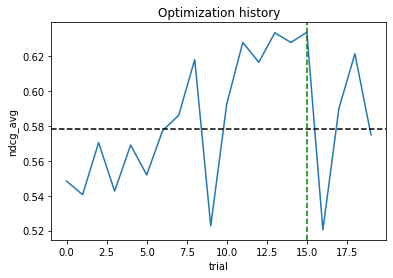

In [14]:
# ANALYZE OPTIMIZATION RESULTS

# plot of trial vs ndcg
# horizontal line = baseline
# vertical line = trial that achieved max ndcg_avg
from matplotlib import pyplot as plt
trial_argmax = optimization_history['user_attrs']['ndcg_avg'].idxmax()
plt.plot(optimization_history['user_attrs']['ndcg_avg'], linestyle='solid')
plt.axhline(baseline_avg_ndcg, color='k', linestyle='--')
plt.axvline(trial_argmax, color='g', linestyle='--')
plt.title("Optimization history")
plt.xlabel('trial')
plt.ylabel('ndcg_avg')

In the above plot, we see that 20 trials may be too few trials since
the variance of the target (ndcg_avg) appears high.
E.g. the ndcg_avg bounces up and down relative to the baseline.

However, an almost 10% gain observed in the best optimization trial
vs the baseline can contribute to improved business-level results like click-thru-rates. 
An A/B experiment would be recommended to test
the potential gains in the new optimized scoring profile vs the baseline.

See the next plot for a more typical experimental result.

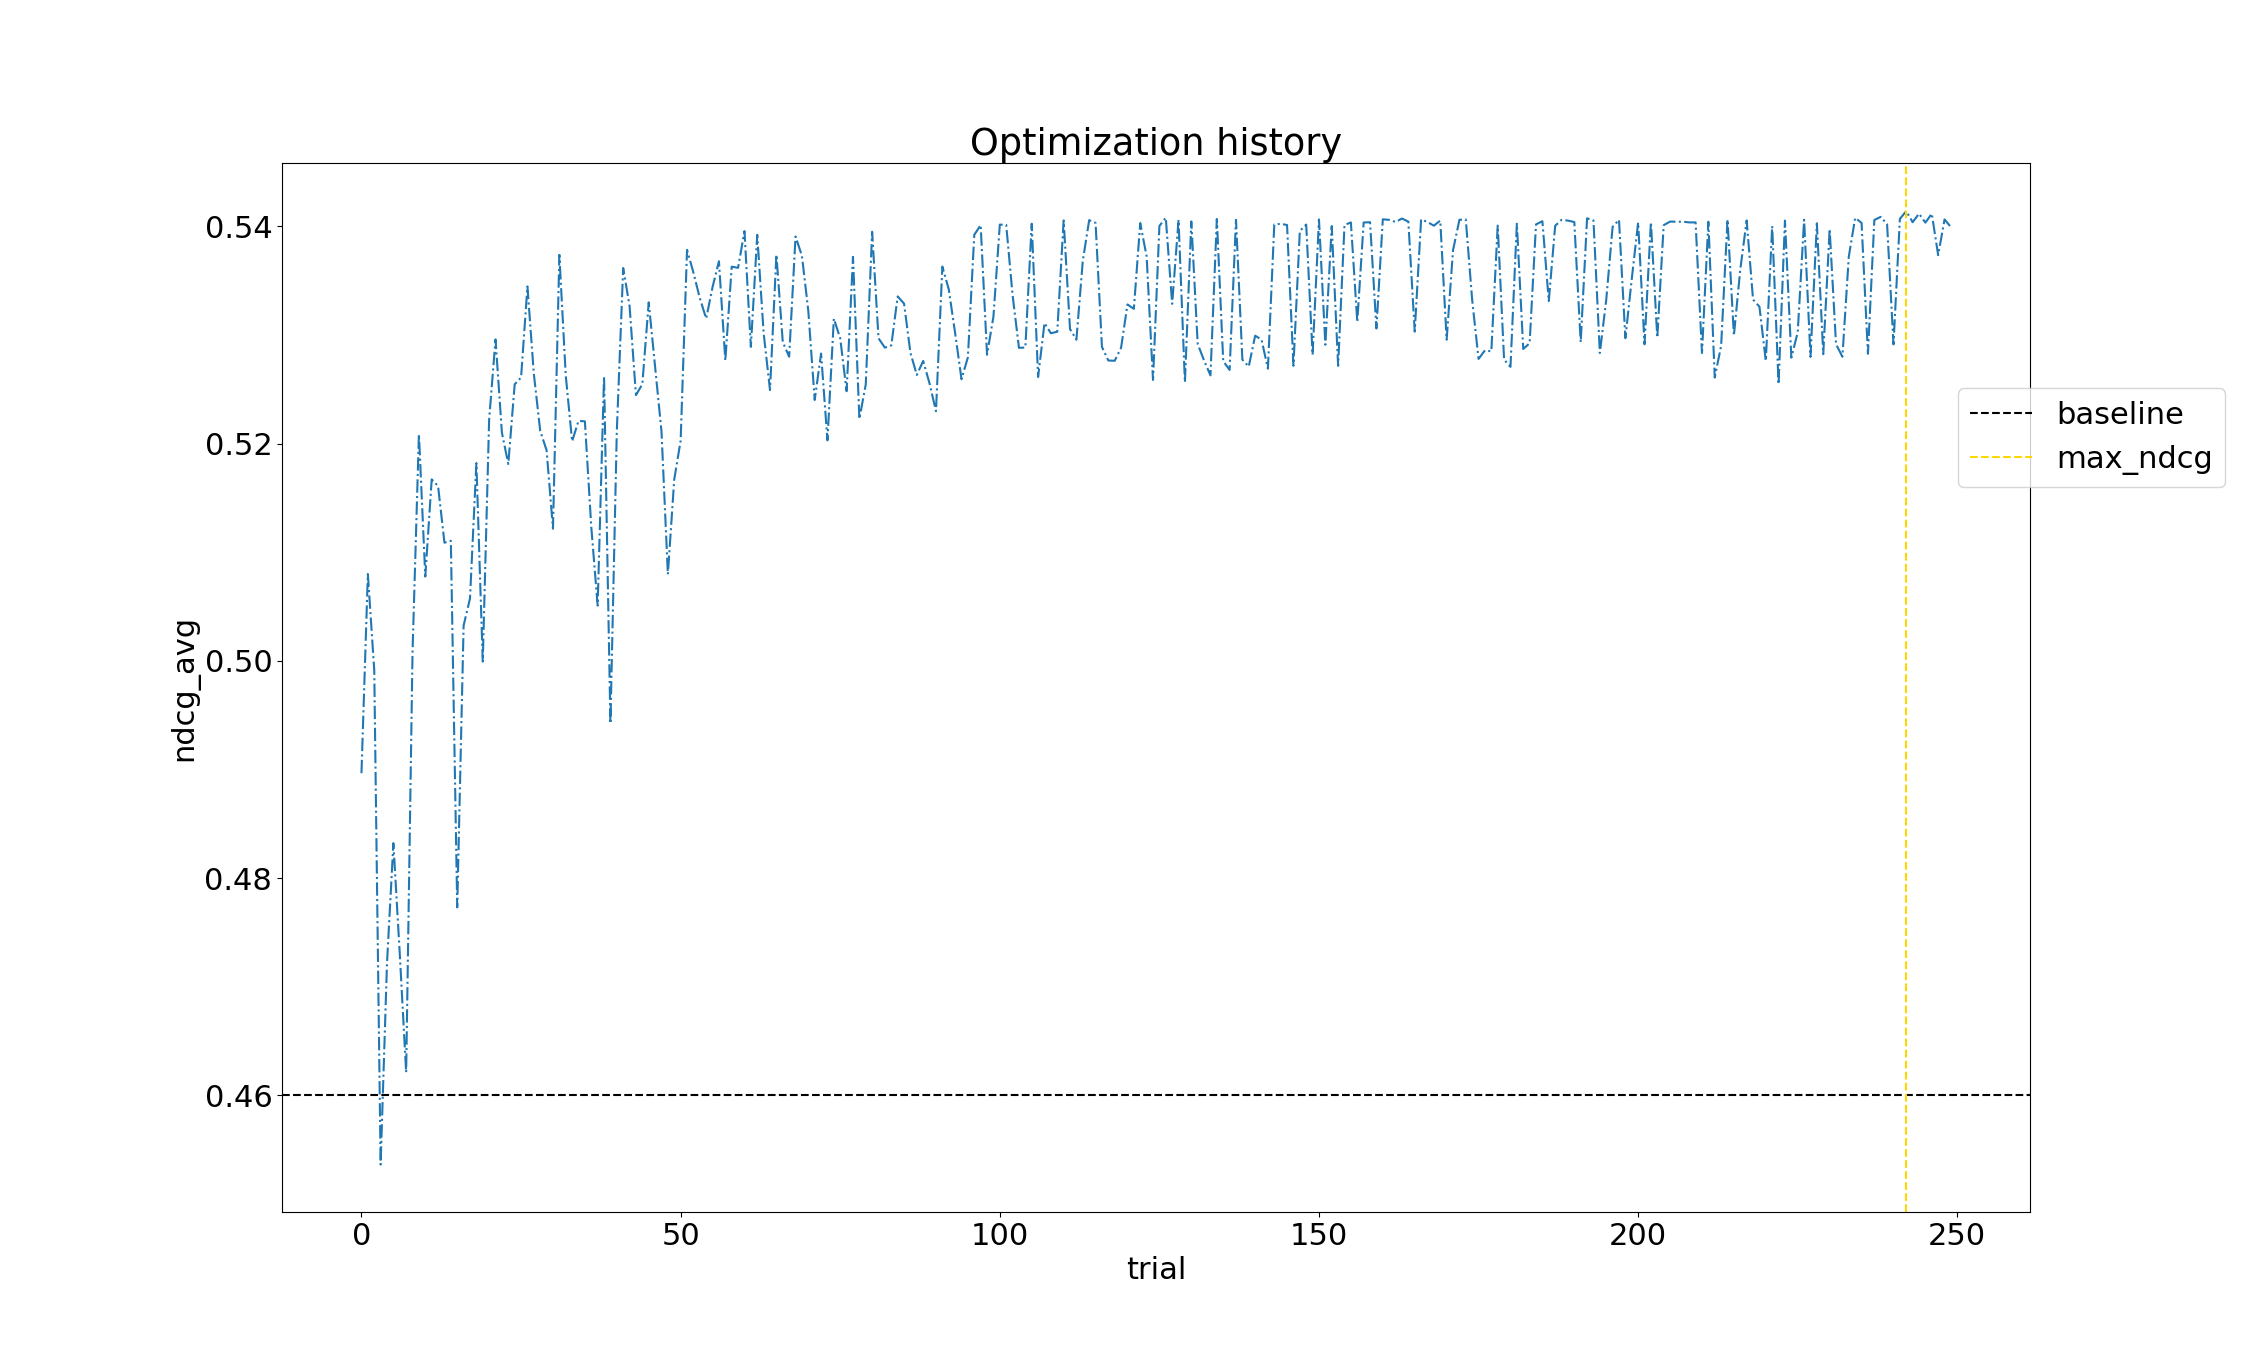

In [36]:
# Plot from a larger experiment on judgement list with 1K "top" queries